In [ ]:
### testing pre-trained singlet classifier for Zhang Melzer et al. 2023
### Created by Madeline E Melzer on 20231110
### Last edited by Madeline E Melzer on 20240129

In [4]:
!pip install xgboost
!pip install sklearn


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a last resort, set the environment variable
        SKLEARN_ALLOW_DEPRECATED

In [2]:
import os
import xgboost
import sklearn
import numpy as np
import pandas as pd
import anndata
import scipy
import xgbfir
import graphviz
import seaborn as sns
import matplotlib.pyplot as plt
import ast
from scipy.io import mmread
from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from joblib import dump, load
from matplotlib import pyplot

np.random.seed(23)

In [9]:
plot_dir = "/Volumes/fsmresfiles/Basic_Sciences/CDB/GoyalLab/People/MadelineMelzer/ZhangMelzerEtAl/plots/classifier/"

In [11]:
dataset_list = ["s1nc_positiveControl"]

for dataset in dataset_list:
    classifiers_dir = "/Volumes/fsmresfiles/Basic_Sciences/CDB/GoyalLab/People/MadelineMelzer/ZhangMelzerEtAl/data/classifier/classifiers/"
    counts_dir = os.path.join("/Volumes/fsmresfiles/Basic_Sciences/CDB/GoyalLab/People/MadelineMelzer/ZhangMelzerEtAl/data/classifier", dataset, "10X_doublets_3/")
    labels_dir = os.path.join("/Volumes/fsmresfiles/Basic_Sciences/CDB/GoyalLab/People/MadelineMelzer/ZhangMelzerEtAl/data/classifier", dataset)
    xgbfir_dir = "/Volumes/fsmresfiles/Basic_Sciences/CDB/GoyalLab/People/MadelineMelzer/ZhangMelzerEtAl/data/classifier/classifiers/importances/"

    #formatting and training classifier
    features, labels_encoded, barcodes_1, matrix_array, genes, genes_list = load_and_preprocess_data(counts_dir, labels_dir)
    #os.chdir(classifiers_dir)
    classifier = load(classifiers_dir + f'{dataset}_9_fit.joblib')

    #getting importances
    booster = classifier.get_booster()
    booster.feature_names = genes_list
    gain = booster.get_score(importance_type='gain')
    cover = booster.get_score(importance_type='cover')
    weight = booster.get_score(importance_type='weight')
    total_gain = booster.get_score(importance_type='total_gain')
    total_cover = booster.get_score(importance_type='total_cover')
    importance_df = pd.DataFrame({'gain': gain, 'cover': cover, 'weight': weight, 
                                  'total_gain': total_gain, 'total_cover': total_cover})
    #importance_df = importance_df.transpose()
    #importance_df['gene_name'] = genes_list
    total_gain_all_genes = importance_df['total_gain'].sum()
    importance_df['average_total_gain'] = importance_df['total_gain'] / total_gain_all_genes
    importance_df['dataset'] = dataset
    importance_df.to_csv(xgbfir_dir + f'{dataset}_importances.csv')
    print(f"{dataset}")
    print(importance_df.head(10))

['TAGLN', 'ACTA2', 'UBE2C', 'CENPF', 'IGFBP5', 'IGFBP7', 'TOP2A', 'MKI67', 'ASPM', 'IGFBP3', 'LUM', 'FN1', 'IGFBP2', 'KRT18', 'CCNB1', 'PLN', 'SFRP1', 'PTTG1', 'VCAM1', 'TMSB4X', 'MT-CYB', 'SPP1', 'TPX2', 'HIST1H4C', 'UBE2S', 'MYOCD', 'CALD1', 'ANKRD1', 'MT-ATP6', 'TFAP2A', 'TDO2', 'BMP2', 'RGS5', 'DKK1', 'NEAT1', 'TPM1', 'BIRC5', 'ARL6IP1', 'TUBA1B', 'AURKA', 'CDC20', 'MT-ND4', 'HMMR', 'ANXA1', 'KPNA2', 'CDKN3', 'COL1A2', 'PMAIP1', 'SORBS2', 'CDK1', 'GTSE1', 'HIST1H1C', 'CENPA', 'CAPN3', 'LGALS1', 'LDHA', 'PRSS23', 'MT-CO3', 'MT-ND1', 'MAP1B', 'NUSAP1', 'PRSS35', 'RND3', 'CXCL14', 'FST', 'ANXA2', 'ID4', 'PEG10', 'LGALS3', 'ID1', 'EDN1', 'TNC', 'ATP1B1', 'CENPE', 'FHL2', 'CKS2', 'CCND1', 'ID3', 'PLAT', 'HMGB2', 'A2M', 'PLK1', 'JAG1', 'JUN', 'DEPDC1', 'SPOCK1', 'ADM', 'H2AFZ', 'ACTC1', 'COL3A1', 'IER3', 'CADPS', 'MT-CO2', 'HAS2', 'AKAP12', 'MEF2C', 'DDIT4', 'MT-ND6', 'NPPB', 'TUBA1C', 'TIMP3', 'CCNB2', 'ADAMTS9', 'DCN', 'PRC1', 'CLSPN', 'NEK2', 'ADAMTS1', 'TFPI2', 'CD9', 'LMO7', 'COL14A

In [3]:
def load_and_preprocess_data(counts_dir, labels_dir):
    os.chdir(counts_dir)

    # Read the .mtx file
    matrix = scipy.io.mmread("matrix.mtx")
    matrix = matrix.transpose()
    matrix_array = matrix.toarray()

    # Read the features and barcodes files
    genes = pd.read_csv("features.tsv.gz", header=None, sep="\t")
    genes_list = genes.index.tolist()
    first_column = genes.columns[0]
    genes = genes.set_index(first_column) #this is to ensure the anndata object is created correctly and that there are no extra columns in the features or barcodes dfs
    barcodes = pd.read_csv("barcodes.tsv.gz", header=None, sep="\t")
    first_column = barcodes.columns[0]
    barcodes = barcodes.set_index(first_column)

    # Create the AnnData object
    data = anndata.AnnData(X=matrix_array, var=genes_list, obs=barcodes)

    # getting singlet and multiplet labels
    os.chdir(labels_dir)
    labels_df = pd.read_csv(f'labels_2.csv') #for "variable doublet rates", indicate _{dataset} here

    ############## Preprocessing data

    # combining features matrix and labels
    data.obs.index = data.obs.index.rename('barcode')
    merged = data.obs.merge(labels_df, on='barcode', how='inner')
    #print(merged.head()) #checking what the merged looks like

    # Extract the features matrix and labels
    features = data.X
    labels = merged['label'].values
    unique_labels, counts = np.unique(labels, return_counts=True)
    print(dict(zip(unique_labels, counts))) #checking the number of singlets and multiplets

    # Encode labels
    label_encoder = LabelEncoder()
    labels_encoded = label_encoder.fit_transform(labels)
    labels_encoded = 1 - labels_encoded #switching the labels so that 1s are multiplets and 0s are singlets, so correclty identified 1s are considered true positives
    counts = np.bincount(labels_encoded)
    #print(counts) #checking that the number of singlets and multiplets is the same as above

    barcodes_1 = data.obs.index.to_numpy() #getting the barcodes for the features matrix to identify the cells that are being classified

    return features, labels_encoded, barcodes_1, matrix_array, genes #genes_list

In [12]:
dataset_list = ["FM01", "FM02", "FM03", "FM04", "FM05", "FM06", "FM08", "non_cancer", "s1nc_positiveControl", "Biorxiv", "TREX", "SPLINTR", "ClonMapper", "LARRY", "watermelon", "cellTag"]

all_datasets_df = []

for dataset in dataset_list:
    file_path = xgbfir_dir + f'{dataset}_importances.csv'
    df = pd.read_csv(file_path, index_col=0)  # Assuming the first column is the index
    df = df.reset_index().rename(columns={'index': 'gene_name'})
    all_datasets_df.append(df)

importances_all = pd.concat(all_datasets_df, ignore_index=True)
importances_all.to_csv(xgbfir_dir + 'allDatasetImportances.csv')

print(len(np.unique(importances_all['gene_name'])))

4534


In [2]:
importances_all = read_csv(xgbfir_dir + 'allDatasetImportances.csv', index_col=0)

NameError: name 'read_csv' is not defined

Number of genes that appear in more than one dataset: 489


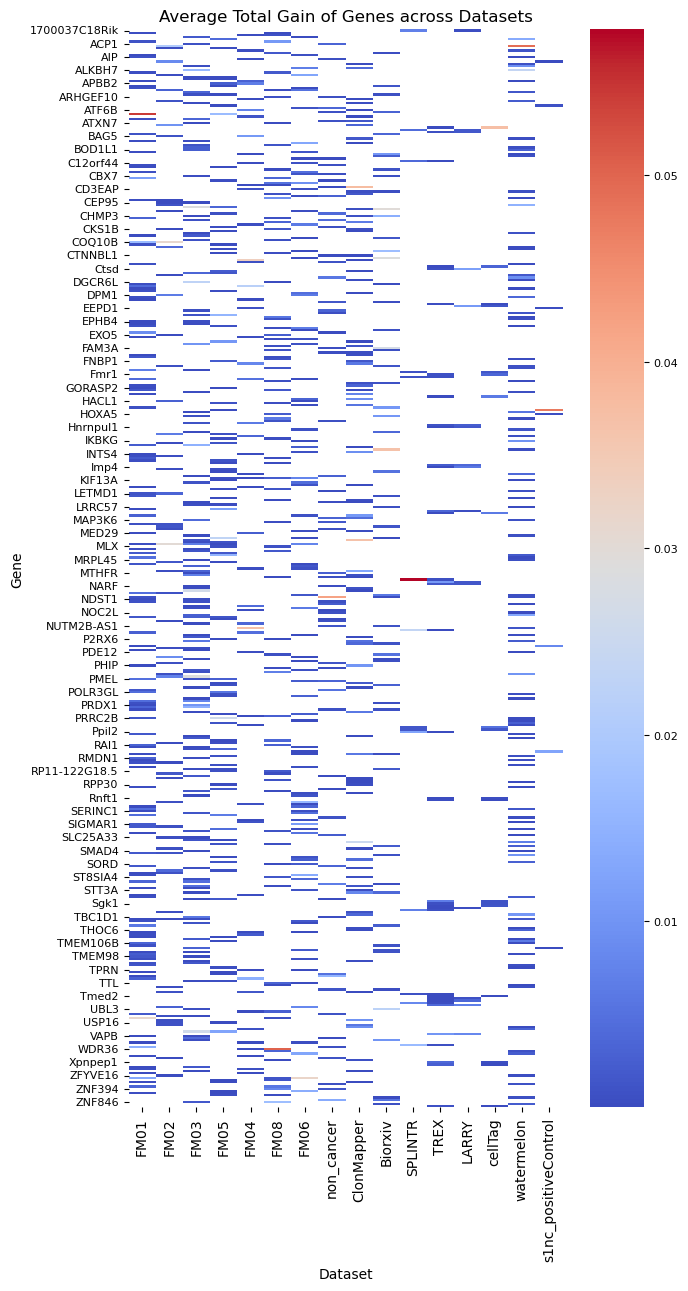

In [47]:
# checking important genes across datasets and getting gains normalized across datasets

selected_datasets = ["SPLINTR", "TREX", "LARRY", "cellTag"]
importances_selected = importances_all[importances_all['dataset'].isin(selected_datasets)].copy()
#gene_counts = importances_selected['gene_name'].value_counts()
#multi_dataset_genes = gene_counts[gene_counts > 1].index  # Adjust the threshold as needed


# Create a DataFrame with genes present in more than one dataset
gene_counts = importances_all['gene_name'].value_counts()
multi_dataset_genes = gene_counts[gene_counts > 1].index

print(f"Number of genes that appear in more than one dataset: {len(np.unique(multi_dataset_genes))}")

importances_multi = importances_all[importances_all['gene_name'].isin(multi_dataset_genes)].copy()

# averaging total gain (percent gain) across datasets
#sum_total_gain_per_gene = importances_multi.groupby('gene_name')['average_total_gain'].transform('sum')
#importances_multi['norm_total_gain'] = importances_multi['average_total_gain'] / sum_total_gain_per_gene

# Pivot the DataFrame to get a matrix of genes vs datasets
heatmap_data = importances_multi.pivot_table(index='gene_name', columns='dataset', values='average_total_gain')
heatmap_data = heatmap_data.reindex(columns = ["FM01", "FM02", "FM03", "FM05", "FM04", "FM08", "FM06", "non_cancer", "ClonMapper", "Biorxiv", "SPLINTR", "TREX", "LARRY", "cellTag", "watermelon", "s1nc_positiveControl"])
#heatmap_data = heatmap_data.reindex(columns = ["SPLINTR", "TREX", "LARRY", "cellTag"])

# Plot the heatmap
plt.figure(figsize=(7, 14))  # Adjust the size as needed
plt.rcParams['ytick.labelsize'] = 8
sns.heatmap(heatmap_data, cmap='coolwarm')  # Choose a colormap that fits your preference
plt.title('Average Total Gain of Genes across Datasets')
plt.ylabel('Gene')
plt.xlabel('Dataset')
#plt.show()

plt.savefig(plot_dir + "importances_moreThan1Dataset.svg", format='svg', bbox_inches='tight')
plt.savefig(plot_dir + "importances_moreThan1Dataset.png", format='png', bbox_inches='tight')



In [48]:
### getting the most important genes for each dataset

# Group by 'dataset' and find the top 10 genes with the highest 'average_total_gain' in each group
top_10_important_genes = importances_all.groupby('dataset').apply(lambda x: x.nlargest(10, 'average_total_gain'))

# Reset the index to clean up the DataFrame
top_10_important_genes.reset_index(drop=True, inplace=True)

# Display the result
print(top_10_important_genes[['dataset', 'gene_name', 'average_total_gain']])

# Identify genes that appear more than once (Are highly important in more than 1 dataset)
gene_names = top_10_important_genes['gene_name'].tolist()
gene_counts = Counter(gene_names)
repeated_genes = {gene: count for gene, count in gene_counts.items() if count > 1}

# Display the repeated genes and their counts
print(repeated_genes)

repeated_genes_details = pd.DataFrame(columns=['gene_name', 'dataset', 'average_total_gain', 'rank'])

# Iterate through each repeated gene
for gene in repeated_genes:
    # Extract rows corresponding to the repeated gene
    gene_rows = top_10_important_genes[top_10_important_genes['gene_name'] == gene]

    # Add a 'rank' column to these rows
    gene_rows['rank'] = gene_rows.groupby('dataset')['average_total_gain'].rank(ascending=False, method='first')

    # Append these rows to the detailed DataFrame
    repeated_genes_details = pd.concat([repeated_genes_details, gene_rows])

# Reset index of the detailed DataFrame
repeated_genes_details.reset_index(drop=True, inplace=True)


# Display the detailed information about repeated genes
print(repeated_genes_details)


        dataset gene_name  average_total_gain
0       Biorxiv      TMX2            0.074457
1       Biorxiv  C11orf71            0.049628
2       Biorxiv  TMEM120B            0.049379
3       Biorxiv     INO80            0.036469
4       Biorxiv      CHDH            0.029669
..          ...       ...                 ...
155  watermelon     TAF10            0.026038
156  watermelon    ALKBH7            0.023775
157  watermelon   PTTG1IP            0.019101
158  watermelon     FOXD2            0.016624
159  watermelon      CFL2            0.015006

[160 rows x 3 columns]


NameError: name 'Counter' is not defined

In [ ]:
### plotting all the trees in the classifier

dataset = "FM01"

classifiers_dir = "/Users/mem3579/Library/CloudStorage/OneDrive-NorthwesternUniversity/Arispe and Goyal Labs/ZhangMelzerEtAl/data/classifier/classifiers/"
counts_dir = os.path.join("/Users/mem3579/Library/CloudStorage/OneDrive-NorthwesternUniversity/Arispe and Goyal Labs/ZhangMelzerEtAl/data/classifier", dataset, "10X_doublets/")
labels_dir = os.path.join("/Users/mem3579/Library/CloudStorage/OneDrive-NorthwesternUniversity/Arispe and Goyal Labs/ZhangMelzerEtAl/data/classifier", dataset)
xgbfir_dir = "/Users/mem3579/Library/CloudStorage/OneDrive-NorthwesternUniversity/Arispe and Goyal Labs/ZhangMelzerEtAl/data/classifier/classifiers/xgbfir/"

#formatting and training classifier
features, labels_encoded, barcodes_1, matrix_array, genes, genes_list = load_and_preprocess_data(counts_dir, labels_dir)

os.chdir(classifiers_dir)
unfit = load(classifiers_dir + 'FM01_1_tree_stratified_unfit.joblib')
X_train, X_test, y_train, y_test, barcodes_train, barcodes_test = train_test_split(features, labels_encoded, barcodes_1, test_size=0.2, random_state=23, shuffle=True, stratify=labels_encoded) # 20% test set, 80% training set
classifier = unfit.fit(X_train, y_train)

classifier.get_booster().feature_names = genes_list

booster = classifier.get_booster()
trees = booster.get_dump()

# Get the number of trees
num_trees = len(trees)

# Plot all the trees
for i in range(3):
    plt.figure(figsize=(100, 100), dpi = 600)  # Adjust the size as needed
    xgboost.plot_tree(classifier, num_trees=i, rankdir='LR')  # 'LR' for horizontal and 'TB' for vertical
    plt.title(f'Tree {i}')
    plt.savefig(f"tree_{i}.png", dpi=600)
    plt.show()

In [6]:
print(summary_data['best_params'])



sample1  sample1                        0.985227  0.928083  0.967280  {'n_estimators': 93   'max_depth': 15   'learning_rate': 0.3021130244747416    'objective': 'binary:logistic'   'min_child_weight': 8     'booster': 'gbtree'}
         sample1_neg_control_singlets   0.509393  0.115139  0.844649  {'n_estimators': 68   'max_depth': 9    'learning_rate': 0.19171374679294007   'objective': 'binary:logistic'   'min_child_weight': 8     'booster': 'gbtree'}
         sample1_neg_control_doublets   0.527491  0.118071  0.816514  {'n_estimators': 46   'max_depth': 14   'learning_rate': 0.7636523710809172    'objective': 'binary:logistic'   'min_child_weight': 8     'booster': 'gbtree'}
         sample1_shuffled               0.984566  0.937930  0.973415  {'n_estimators': 84   'max_depth': 3    'learning_rate': 0.31771889498819356   'objective': 'binary:logistic'   'min_child_weight': 7     'booster': 'gbtree'}
         sample1_neg_control_scrambled  0.459207  0.096459  0.838446  {'n_estimators

In [3]:
### hyperparameter parsing

summary_data = pd.read_csv("/Volumes/fsmresfiles/Basic_Sciences/CDB/GoyalLab/People/MadelineMelzer/ZhangMelzerEtAl/data/classifier/results/datasetSummaries/s1s2/sample1_sample2_classifiers.csv")

def parse_params(row):
    try:
        # Attempt to convert the string to a dictionary
        params = ast.literal_eval(row)
        # Filter out keys with value None
        return {k: v for k, v in params.items() if v is not None}
    except (ValueError, SyntaxError):
        # Return an empty dictionary for rows with "FM01 parameters" or other invalid formats
        return {}

# Apply the parsing function to the 'best_params' column
parsed_params = summary_data['best_params'].apply(parse_params)

# Convert the parsed parameters to a DataFrame and join with the original DataFrame
params_df = pd.DataFrame(parsed_params.tolist())
summary_data = summary_data.join(params_df)



#summary_data.to_csv("/Users/mem3579/Library/CloudStorage/OneDrive-NorthwesternUniversity/Arispe and Goyal Labs/ZhangMelzerEtAl/data/classifier/results/summary_10_hyperparams.csv")

ValueError: cannot join with no overlapping index names

In [ ]:
### plotting hyperparameters effect on AUPRC value for ONE DATASET

# Filter the DataFrame for dataset "FM01"
fm01_data = summary_data[summary_data['dataset'] == 'Biorxiv']

# List of numeric hyperparameters to plot
numeric_hyperparameters = ['n_estimators', 'max_depth', 'learning_rate', 'min_child_weight', 
                           'gamma', 'subsample', 'reg_alpha', 'reg_lambda', 'scale_pos_weight']

# Determine the number of rows and columns for subplots
n_rows = 3
n_cols = 3

# Create a figure for subplots
plt.figure(figsize=(15, 5 * n_rows))

# Create a subplot for each hyperparameter
for i, param in enumerate(numeric_hyperparameters, 1):
    plt.subplot(n_rows, n_cols, i)
    filtered_data = fm01_data[fm01_data['auprc'] > 0.5]
    sns.scatterplot(x=filtered_data[param], y=filtered_data['auprc'])
    sns.regplot(x=param, y='auprc', data=filtered_data, scatter_kws={'s': 10})
    #sns.scatterplot(x=summary_data[param], y=summary_data['auprc'])
    plt.title(f'AUPRC vs {param}')
    plt.xlabel(param)
    plt.ylabel('AUPRC')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

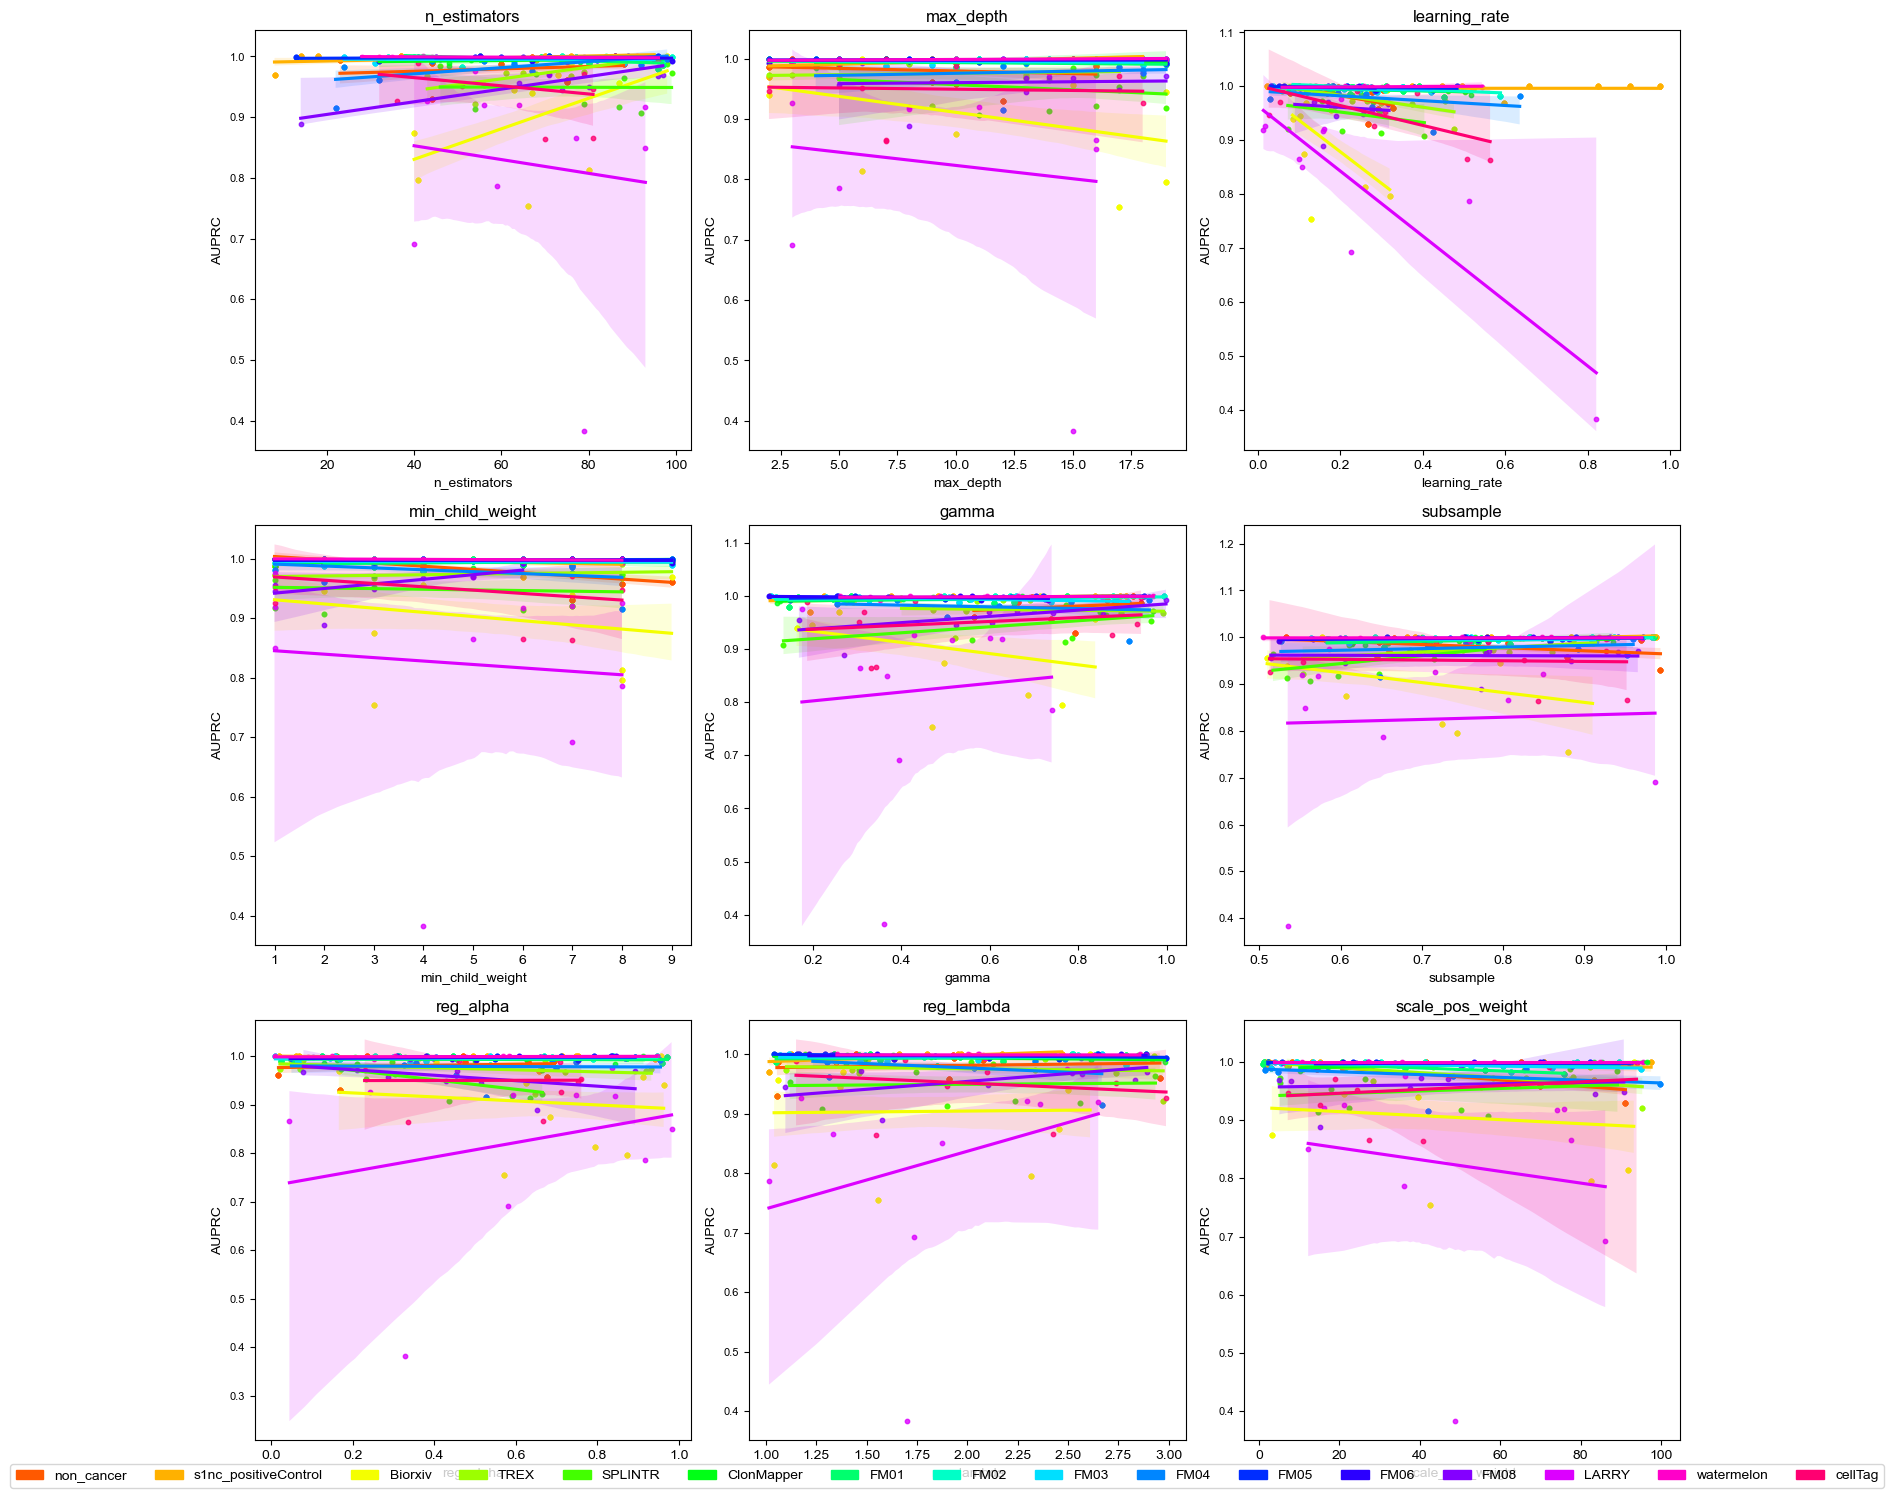

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


# Filter data for AUPRC > 0.99
filtered_data = summary_data[summary_data['dataset'] == summary_data['condition']]

# List of numeric hyperparameters to plot
numeric_hyperparameters = ['n_estimators', 'max_depth', 'learning_rate', 'min_child_weight', 
                           'gamma', 'subsample', 'reg_alpha', 'reg_lambda', 'scale_pos_weight']

# Determine the number of rows and columns for subplots
n_rows = 3
n_cols = 3

# Create a color palette
unique_datasets = filtered_data['dataset'].unique()
palette = sns.color_palette("hsv", len(unique_datasets))
dataset_colors = dict(zip(unique_datasets, palette))

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 15))
axes = axes.flatten()

# Plot each hyperparameter
for i, param in enumerate(numeric_hyperparameters):
    ax = axes[i]
    for dataset in unique_datasets:
        subset = filtered_data[filtered_data['dataset'] == dataset]
        sns.regplot(x=param, y='auprc', data=subset, ax=ax, scatter_kws={'s': 10}, line_kws={'color': dataset_colors[dataset]}, label=dataset, color=dataset_colors[dataset])

    ax.set_title(f'{param}')
    ax.set_xlabel(param)
    ax.set_ylabel('AUPRC')
    ax.grid(False)

# Adjust layout
plt.tight_layout()
plt.rcParams['font.family'] = 'Arial'

# Create custom legend
legend_patches = [mpatches.Patch(color=dataset_colors[dataset], label=dataset) for dataset in unique_datasets]
plt.figlegend(handles=legend_patches, loc='lower center', ncol=len(unique_datasets), bbox_to_anchor=(0.5, 0.0))#

# Show the plot
plt.show()

#fig.savefig("/Volumes/fsmresfiles/Basic_Sciences/CDB/GoyalLab/People/MadelineMelzer/ZhangMelzerEtAl/plots/classifier/hyperaparams_auprc_all_datasets.svg", format='svg', bbox_inches='tight')
#fig.savefig("/Volumes/fsmresfiles/Basic_Sciences/CDB/GoyalLab/People/MadelineMelzer/ZhangMelzerEtAl/plots/classifier/hyperaparams_auprc_all_datasets.png", format='png', bbox_inches='tight')


In [38]:
### classifier fit to sample 1 data to predict sample 2 outcome
dataset_main = "SPLINTR"

classifiers_dir = os.path.join("/Volumes/fsmresfiles/Basic_Sciences/CDB/GoyalLab/People/MadelineMelzer/ZhangMelzerEtAl/data/classifier/crossExperiment/classifiers", dataset_main)
print(classifiers_dir)

# loading and formatting sample 2 data

dataset = "sample2"
counts_dir = os.path.join("/Volumes/fsmresfiles/Basic_Sciences/CDB/GoyalLab/People/MadelineMelzer/ZhangMelzerEtAl/data/classifier/crossExperiment", dataset_main, "10X", dataset)
labels_dir = os.path.join("/Volumes/fsmresfiles/Basic_Sciences/CDB/GoyalLab/People/MadelineMelzer/ZhangMelzerEtAl/data/classifier/crossExperiment", dataset_main, "10X", dataset)
results_dir = "/Volumes/fsmresfiles/Basic_Sciences/CDB/GoyalLab/People/MadelineMelzer/ZhangMelzerEtAl/data/classifier/crossExperiment/results/predictions/"
summaries_dir = "/Volumes/fsmresfiles/Basic_Sciences/CDB/GoyalLab/People/MadelineMelzer/ZhangMelzerEtAl/data/classifier/crossExperiment/results/datasetSummaries/"
features, labels_encoded, barcodes_1, matrix_array, genes = load_and_preprocess_data(counts_dir, labels_dir)

summary_df = pd.DataFrame(columns = ["dataset", "condition", "auroc", "auprc", "accuracy", "best_params"])

for count in range(10):
    sample1Classifier = load(classifiers_dir + f'/sample1_{count}_fit.joblib') #using the classifier that was fit to sample 1
    # predict sample 2 outcome using sample 1's classifier
    preds_proba = sample1Classifier.predict_proba(features)[:,1]  # Get probabilities of the positive class (multiplets- 1)
    auroc = roc_auc_score(labels_encoded, preds_proba) # Calculate AUROC
    print(f"AUROC: {auroc}")
    auprc = average_precision_score(labels_encoded, preds_proba) # Calculate AUPRC
    print(f"AUPRC: {auprc}")
    y_preds = sample1Classifier.predict(features) # Predict labels on the test set
    accuracy = accuracy_score(labels_encoded, y_preds) # Calculate accuracy
    print(f"Accuracy: {accuracy}")  
    summary_dict = {"dataset": dataset, "condition": "sample1", "auroc": auroc, "auprc": auprc, "accuracy": accuracy}  
    summary_df = pd.concat([summary_df, pd.DataFrame([summary_dict])], ignore_index=True)

# loading and formatting sample 1 data

dataset = "sample1"
counts_dir = os.path.join("/Volumes/fsmresfiles/Basic_Sciences/CDB/GoyalLab/People/MadelineMelzer/ZhangMelzerEtAl/data/classifier/crossExperiment", dataset_main, "10X", dataset)
labels_dir = os.path.join("/Volumes/fsmresfiles/Basic_Sciences/CDB/GoyalLab/People/MadelineMelzer/ZhangMelzerEtAl/data/classifier/crossExperiment", dataset_main, "10X", dataset)
results_dir = "/Volumes/fsmresfiles/Basic_Sciences/CDB/GoyalLab/People/MadelineMelzer/ZhangMelzerEtAl/data/classifier/crossExperiment/results/predictions/"
summaries_dir = "/Volumes/fsmresfiles/Basic_Sciences/CDB/GoyalLab/People/MadelineMelzer/ZhangMelzerEtAl/data/classifier/crossExperiment/results/datasetSummaries/"
features, labels_encoded, barcodes_1, matrix_array, genes = load_and_preprocess_data(counts_dir, labels_dir)

for count in range(10):
    sample2Classifier = load(classifiers_dir + f'/sample2_{count}_fit.joblib')
    # predict sample 1 outcome using sample 2's classifier
    preds_proba = sample2Classifier.predict_proba(features)[:,1]  # Get probabilities of the positive class (multiplets- 1)
    auroc = roc_auc_score(labels_encoded, preds_proba) # Calculate AUROC
    print(f"AUROC: {auroc}")
    auprc = average_precision_score(labels_encoded, preds_proba) # Calculate AUPRC
    print(f"AUPRC: {auprc}")
    y_preds = sample2Classifier.predict(features) # Predict labels on the test set
    accuracy = accuracy_score(labels_encoded, y_preds) # Calculate accuracy
    print(f"Accuracy: {accuracy}")  
    summary_dict = {"dataset": dataset, "condition": "sample2", "auroc": auroc, "auprc": auprc, "accuracy": accuracy}  
    summary_df = pd.concat([summary_df, pd.DataFrame([summary_dict])], ignore_index=True)
    
summary_df.to_csv(os.path.join(summaries_dir, dataset_main, f"summary_s1s2_bothClassifiers.csv"), index = False)


/Volumes/fsmresfiles/Basic_Sciences/CDB/GoyalLab/People/MadelineMelzer/ZhangMelzerEtAl/data/classifier/crossExperiment/classifiers/SPLINTR
{'doublet': 70, 'singlet': 630}
AUROC: 0.8506349206349206
AUPRC: 0.5634708248391054
Accuracy: 0.8542857142857143
AUROC: 0.8463265306122449
AUPRC: 0.4720907383276552
Accuracy: 0.8457142857142858
AUROC: 0.908140589569161
AUPRC: 0.6156219111191038
Accuracy: 0.91
AUROC: 0.8630612244897959
AUPRC: 0.5518612522638814
Accuracy: 0.8428571428571429
AUROC: 0.9170068027210885
AUPRC: 0.6839142356079978
Accuracy: 0.9
AUROC: 0.9129931972789116
AUPRC: 0.6427272840702202
Accuracy: 0.8471428571428572
AUROC: 0.862312925170068
AUPRC: 0.5036191206244227
Accuracy: 0.10142857142857142
AUROC: 0.9239455782312926
AUPRC: 0.6633309466491533


/var/folders/lj/t95zdh7s6q1728bs885tygr0f794qx/T/ipykernel_36566/4008423209.py:30: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  summary_df = pd.concat([summary_df, pd.DataFrame([summary_dict])], ignore_index=True)


Accuracy: 0.9171428571428571
AUROC: 0.8836054421768706
AUPRC: 0.5460890714317069
Accuracy: 0.8557142857142858
AUROC: 0.8514512471655329
AUPRC: 0.42645631239518467
Accuracy: 0.9071428571428571
{'doublet': 96, 'singlet': 864}
AUROC: 0.9224657600308641
AUPRC: 0.4812857340594399
Accuracy: 0.8979166666666667
AUROC: 0.8334177276234568
AUPRC: 0.3589449606065578
Accuracy: 0.9010416666666666
AUROC: 0.9242018711419753
AUPRC: 0.6614494047411806
Accuracy: 0.9166666666666666
AUROC: 0.9239848572530864
AUPRC: 0.5892005306900046
Accuracy: 0.9072916666666667
AUROC: 0.9305917245370371
AUPRC: 0.5243235807173677
Accuracy: 0.8947916666666667
AUROC: 0.9046706211419753
AUPRC: 0.49502194120856524
Accuracy: 0.8989583333333333
AUROC: 0.8825472608024691
AUPRC: 0.4254922407660758
Accuracy: 0.9
AUROC: 0.8914930555555556
AUPRC: 0.4591735120314949
Accuracy: 0.8979166666666667
AUROC: 0.8834635416666666
AUPRC: 0.4413469507216562
Accuracy: 0.9
AUROC: 0.9109760802469136
AUPRC: 0.5145421796451722
Accuracy: 0.9


In [29]:
print(summary_df)



summary_df['auprc'].mean()

   dataset condition     auroc     auprc  accuracy best_params
0  sample1   sample1  0.922466  0.481286  0.897917         NaN
1  sample1   sample1  0.833418  0.358945  0.901042         NaN
2  sample1   sample1  0.924202  0.661449  0.916667         NaN
3  sample1   sample1  0.923985  0.589201  0.907292         NaN
4  sample1   sample1  0.930592  0.524324  0.894792         NaN
5  sample1   sample1  0.904671  0.495022  0.898958         NaN
6  sample1   sample1  0.882547  0.425492  0.900000         NaN
7  sample1   sample1  0.891493  0.459174  0.897917         NaN
8  sample1   sample1  0.883464  0.441347  0.900000         NaN
9  sample1   sample1  0.910976  0.514542  0.900000         NaN


0.49507810351875153

In [20]:
def train_classifier(features, labels_encoded, barcodes_1, condition):
    # split into training, testing, and validation sets
    X_train, X_test_temp, y_train, y_test_temp, barcodes_train, barcodes_test = train_test_split(features, labels_encoded, barcodes_1, test_size=0.4, random_state=count, shuffle=True, stratify=labels_encoded) # 40% test set, 60% training set
    X_test, X_valid, y_test, y_valid, barcodes_test, barcodes_valid = train_test_split(X_test_temp, y_test_temp, barcodes_test, test_size=0.5, random_state=count, shuffle=True, stratify=y_test_temp) # Split 50% of the test set into a validation set
    #print the first 10 rows of the training set
    print(X_train[:10])
    #print the first 10 rows of the test_temp set
    print(X_test_temp[:10])


    # Define the hyperparameter space
    space_tree = {
        'n_estimators': hp.choice('n_estimators', range(1, 100)),
        'max_depth': hp.choice('max_depth', range(1, 20)),
        'learning_rate': hp.uniform('learning_rate', 0.01, 1),
        'objective': 'binary:logistic',
        'min_child_weight': hp.choice('min_child_weight', range(1, 10)),
        'gamma': hp.uniform('gamma', 0.1, 1.0),
        'subsample': hp.uniform('subsample', 0.5, 1),
        'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
        'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
        'reg_lambda': hp.uniform('reg_lambda', 1.0, 3.0),
        'scale_pos_weight': hp.uniform('scale_pos_weight', 1, 100),
        'booster': 'gbtree'
    }

    # Define objective function
    def objective(params):
        bst = XGBClassifier(**params, random_state=count)
        bst.fit(X_train, y_train)
        preds = bst.predict(X_valid)
        preds_proba = bst.predict_proba(X_valid)[:, 1]
        accuracy = accuracy_score(y_valid, preds)
        auroc = roc_auc_score(y_valid, preds_proba)  # Calculate AUROC
        auprc = average_precision_score(y_valid, preds_proba)  # Calculate AUPRC
        return {'loss': -auprc, 'accuracy': accuracy, 'status': STATUS_OK, 'auroc': auroc, 'auprc': auprc}

    # Run the hyperparameter optimization
    trials_tree = Trials()
    best_tree = fmin(fn=objective, space=space_tree, algo=tpe.suggest, max_evals=10, trials=trials_tree)
    print(f"{condition} Best parameters for tree: {best_tree}")

    # Summary of the success of the hyperparameter optimization
    best_tree_score = min(trials_tree.results, key=lambda x: x['loss'])
    print(f"{condition} Best tree score: {best_tree_score}")

    # Adjusting the hyperparameters
    best_params_tree = {
        'n_estimators': best_tree['n_estimators'] + 1,  # +1 because hp.choice returns an index
        'max_depth': best_tree['max_depth'] + 1,        # +1 for the same reason
        'learning_rate': best_tree['learning_rate'],
        'objective': 'binary:logistic',
        'min_child_weight': best_tree['min_child_weight'] + 1,  # Adjust if needed
        'gamma': best_tree['gamma'],
        'subsample': best_tree['subsample'],
        'reg_alpha': best_tree['reg_alpha'],
        'reg_lambda': best_tree['reg_lambda'],
        'scale_pos_weight': best_tree['scale_pos_weight'],
        'booster': 'gbtree'
    }

    # Retrain the classifier with the best hyperparameters
    bst_best = XGBClassifier(**best_params_tree, random_state=23)
    if count == 10:
        dump(bst_best, classifiers_dir + f'{dataset}_sample2_unfit.joblib') #saving unfit classifier
    bst_best.fit(X_train, y_train)
    if count == 10:
        dump(bst_best, classifiers_dir + f'{dataset}_sample2_fit.joblib') #saving fit classifier

    preds_proba = bst_best.predict_proba(X_test)[:,1]  # Get probabilities of the positive class (multiplets- 1)
    auroc = roc_auc_score(y_test, preds_proba) # Calculate AUROC
    print(f"{condition} AUROC: {auroc}")
    auprc = average_precision_score(y_test, preds_proba) # Calculate AUPRC
    print(f"{condition} AUPRC: {auprc}")
    y_preds = bst_best.predict(X_test) # Predict labels on the test set
    accuracy = accuracy_score(y_test, y_preds) # Calculate accuracy
    print(f"{condition} Accuracy: {accuracy}")
    results = pd.DataFrame({
        'barcode': barcodes_test,
        'prediction probability': preds_proba,
        'predicted': y_preds,
        'actual': y_test
    })
    results.to_csv(os.path.join(results_dir, dataset ,f"{condition}_sample2Classifier_predicted_actual.csv"))

    summary_dict = {"dataset": dataset, "condition": condition, "auroc": auroc, "auprc": auprc, "accuracy": accuracy, "best_params": best_params_tree}

    return summary_dict

In [10]:
# loading and formatting sample 2 data for sample 1 classifier
dataset_main = "TREX"

classifiers_dir = os.path.join("/Volumes/fsmresfiles/Basic_Sciences/CDB/GoyalLab/People/MadelineMelzer/ZhangMelzerEtAl/data/classifier/crossExperiment/classifiers", dataset_main)
summaries_dir = "/Volumes/fsmresfiles/Basic_Sciences/CDB/GoyalLab/People/MadelineMelzer/ZhangMelzerEtAl/data/classifier/crossExperiment/results/datasetSummaries/"

# dataset = "sample2"
# counts_dir = os.path.join("/Volumes/fsmresfiles/Basic_Sciences/CDB/GoyalLab/People/MadelineMelzer/ZhangMelzerEtAl/data/classifier/crossExperiment", dataset_main, "10X", dataset)
# labels_dir = os.path.join("/Volumes/fsmresfiles/Basic_Sciences/CDB/GoyalLab/People/MadelineMelzer/ZhangMelzerEtAl/data/classifier/crossExperiment", dataset_main, "10X", dataset)
# results_dir = "/Volumes/fsmresfiles/Basic_Sciences/CDB/GoyalLab/People/MadelineMelzer/ZhangMelzerEtAl/data/classifier/crossExperiment/results/predictions/"
# summaries_dir = "/Volumes/fsmresfiles/Basic_Sciences/CDB/GoyalLab/People/MadelineMelzer/ZhangMelzerEtAl/data/classifier/crossExperiment/results/datasetSummaries/"
# features, labels_encoded, barcodes_1, matrix_array, genes = load_and_preprocess_data(counts_dir, labels_dir)

# summary_df = pd.DataFrame(columns = ["dataset", "condition", "auroc", "auprc", "accuracy", "best_params"])

# for count in range(10):
#     sample1Classifier = load(classifiers_dir + f'/sample1_{count}_fit.joblib') #using the classifier that was fit to sample 1
#     # predict sample 2 outcome using sample 1's classifier
#     preds_proba = sample1Classifier.predict_proba(features)[:,1]  # Get probabilities of the positive class (multiplets- 1)
#     auroc = roc_auc_score(labels_encoded, preds_proba) # Calculate AUROC
#     print(f"AUROC: {auroc}")
#     auprc = average_precision_score(labels_encoded, preds_proba) # Calculate AUPRC
#     print(f"AUPRC: {auprc}")
#     y_preds = sample1Classifier.predict(features) # Predict labels on the test set
#     accuracy = accuracy_score(labels_encoded, y_preds) # Calculate accuracy
#     print(f"Accuracy: {accuracy}")  
#     summary_dict = {"dataset": dataset, "condition": "FateMap2_B_human", "auroc": auroc, "auprc": auprc, "accuracy": accuracy}  
#     summary_df = pd.concat([summary_df, pd.DataFrame([summary_dict])], ignore_index=True)

# loading and formatting sample 1 data for sample 3 classifier

dataset = "sample1"
counts_dir = os.path.join("/Volumes/fsmresfiles/Basic_Sciences/CDB/GoyalLab/People/MadelineMelzer/ZhangMelzerEtAl/data/classifier/crossExperiment", dataset_main, "10X", dataset)
labels_dir = os.path.join("/Volumes/fsmresfiles/Basic_Sciences/CDB/GoyalLab/People/MadelineMelzer/ZhangMelzerEtAl/data/classifier/crossExperiment", dataset_main, "10X", dataset)
results_dir = "/Volumes/fsmresfiles/Basic_Sciences/CDB/GoyalLab/People/MadelineMelzer/ZhangMelzerEtAl/data/classifier/crossExperiment/results/predictions/"
summaries_dir = "/Volumes/fsmresfiles/Basic_Sciences/CDB/GoyalLab/People/MadelineMelzer/ZhangMelzerEtAl/data/classifier/crossExperiment/results/datasetSummaries/"
features, labels_encoded, barcodes_1, matrix_array, genes = load_and_preprocess_data(counts_dir, labels_dir)

for count in range(7,10):
    sample2Classifier = load(classifiers_dir + f'/sample2_{count}_fit.joblib')
    # predict sample 1 outcome using sample 2's classifier
    preds_proba = sample2Classifier.predict_proba(features)[:,1]  # Get probabilities of the positive class (multiplets- 1)
    auroc = roc_auc_score(labels_encoded, preds_proba) # Calculate AUROC
    print(f"AUROC: {auroc}")
    auprc = average_precision_score(labels_encoded, preds_proba) # Calculate AUPRC
    print(f"AUPRC: {auprc}")
    y_preds = sample2Classifier.predict(features) # Predict labels on the test set
    accuracy = accuracy_score(labels_encoded, y_preds) # Calculate accuracy
    print(f"Accuracy: {accuracy}")  
    summary_dict = {"dataset": dataset, "condition": "ClonMapper2_B_human", "auroc": auroc, "auprc": auprc, "accuracy": accuracy}  
    summary_df = pd.concat([summary_df, pd.DataFrame([summary_dict])], ignore_index=True)
    
#summary_df.to_csv(os.path.join(summaries_dir, dataset_main, f"summary_s1_100evals_Classifier.csv"), index = False)

{'doublet': 337, 'singlet': 3033}
AUROC: 0.7519628302324285
AUPRC: 0.2866815685129187
Accuracy: 0.7237388724035608
AUROC: 0.7494552993236612
AUPRC: 0.30716360099343326
Accuracy: 0.7071216617210683
AUROC: 0.8027630779526103
AUPRC: 0.4003587197166382
Accuracy: 0.8222551928783383


In [8]:
summary_df['auprc'].mean()

0.7243079829005377

In [26]:
######### testing classifiers on scrambled samples as a negative control

dataset_main = "TREX"

classifiers_dir = os.path.join("/Volumes/fsmresfiles/Basic_Sciences/CDB/GoyalLab/People/MadelineMelzer/ZhangMelzerEtAl/data/classifier/crossExperiment/classifiers", dataset_main)
print(classifiers_dir)

# loading and formatting sample 2 data
dataset_classifier = "sample1"
dataset_predict = "sample2"

counts_dir = os.path.join("/Volumes/fsmresfiles/Basic_Sciences/CDB/GoyalLab/People/MadelineMelzer/ZhangMelzerEtAl/data/classifier/crossExperiment", dataset_main, "10X", dataset_predict)
labels_dir = os.path.join("/Volumes/fsmresfiles/Basic_Sciences/CDB/GoyalLab/People/MadelineMelzer/ZhangMelzerEtAl/data/classifier/crossExperiment", dataset_main, "10X", dataset_predict)
results_dir = "/Volumes/fsmresfiles/Basic_Sciences/CDB/GoyalLab/People/MadelineMelzer/ZhangMelzerEtAl/data/classifier/crossExperiment/results/predictions/"
summaries_dir = "/Volumes/fsmresfiles/Basic_Sciences/CDB/GoyalLab/People/MadelineMelzer/ZhangMelzerEtAl/data/classifier/crossExperiment/results/datasetSummaries/"
features, labels_encoded, barcodes_1, matrix_array, genes = load_and_preprocess_data(counts_dir, labels_dir)

#scerambling matrix
flattened_matrix = matrix_array.flatten()
np.random.shuffle(flattened_matrix)
scrambled_matrix_array = flattened_matrix.reshape(matrix_array.shape)
features_scrambled = scrambled_matrix_array

summary_scrambled = pd.DataFrame(columns = ["dataset", "condition", "auroc", "auprc", "accuracy", "best_params"])

for count in range(10):
    sample1Classifier = load(classifiers_dir + f'/{dataset_classifier}_{count}_fit.joblib')
    # predict sample 2 outcome using sample 1's classifier
    preds_proba = sample1Classifier.predict_proba(features_scrambled)[:,1]  # Get probabilities of the positive class (multiplets- 1)
    auroc = roc_auc_score(labels_encoded, preds_proba) # Calculate AUROC
    print(f"AUROC: {auroc}")
    auprc = average_precision_score(labels_encoded, preds_proba) # Calculate AUPRC
    print(f"AUPRC: {auprc}")
    y_preds = sample1Classifier.predict(features_scrambled) # Predict labels on the test set
    accuracy = accuracy_score(labels_encoded, y_preds) # Calculate accuracy
    print(f"Accuracy: {accuracy}")
    summary_dict = {"dataset": dataset_predict, "condition": dataset_classifier, "auroc": auroc, "auprc": auprc, "accuracy": accuracy}  
    summary_scrambled = pd.concat([summary_scrambled, pd.DataFrame([summary_dict])], ignore_index=True)

summary_scrambled.to_csv(os.path.join(summaries_dir, dataset_main, f"{dataset_predict}Scrambled_{dataset_classifier}Classifier.csv"), index = False)
print(summary_scrambled['auprc'].mean())


/Volumes/fsmresfiles/Basic_Sciences/CDB/GoyalLab/People/MadelineMelzer/ZhangMelzerEtAl/data/classifier/crossExperiment/classifiers/all
{'doublet': 135, 'singlet': 1215}
AUROC: 0.4845297972869989
AUPRC: 0.09321729780565267
Accuracy: 0.8711111111111111
AUROC: 0.46733729614388053
AUPRC: 0.09422591646763794
Accuracy: 0.8992592592592593
AUROC: 0.5545069349184575
AUPRC: 0.12311300402363684
Accuracy: 0.8955555555555555
AUROC: 0.5392592592592593
AUPRC: 0.11099024633054883
Accuracy: 0.8577777777777778


/var/folders/lj/t95zdh7s6q1728bs885tygr0f794qx/T/ipykernel_49194/2298357742.py:38: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  summary_scrambled = pd.concat([summary_scrambled, pd.DataFrame([summary_dict])], ignore_index=True)


AUROC: 0.5295960981557689
AUPRC: 0.1065188248370808
Accuracy: 0.8859259259259259
AUROC: 0.47351928059746995
AUPRC: 0.09362819682487944
Accuracy: 0.8644444444444445
AUROC: 0.5343697607072092
AUPRC: 0.11074577843032846
Accuracy: 0.9
AUROC: 0.5036183508611493
AUPRC: 0.10118887705077392
Accuracy: 0.8725925925925926
AUROC: 0.5337296143880506
AUPRC: 0.10690472086104916
Accuracy: 0.8859259259259259
AUROC: 0.4583630544124371
AUPRC: 0.08701685328825291
Accuracy: 0.8466666666666667
0.1027549715919841


In [9]:
import pandas as pd
import ast

# Load the dataset
file_path = "/Volumes/fsmresfiles/Basic_Sciences/CDB/GoyalLab/People/MadelineMelzer/ZhangMelzerEtAl/data/classifier/results/datasetSummaries/s1s2/sample1_sample2_classifiers.csv"
summary_data = pd.read_csv(file_path)

# Define the function to parse parameters
def parse_params(row):
    try:
        # Attempt to convert the string to a dictionary
        params = ast.literal_eval(row)
        # Filter out keys with value None
        return {k: v for k, v in params.items() if v is not None}
    except (ValueError, SyntaxError):
        # Return an empty dictionary for rows with "FM01 parameters" or other invalid formats
        return {}

# Apply the parsing function to the 'best_params' column
parsed_params = summary_data['best_params'].apply(parse_params)

# Convert the parsed parameters to a DataFrame and reset its index
params_df = pd.DataFrame(parsed_params.tolist()).reset_index(drop=True)

# Reset the index of the original DataFrame to ensure it matches
summary_data = summary_data.reset_index(drop=True)

# Join the parsed parameters DataFrame with the original DataFrame
summary_data = summary_data.join(params_df)

# Display the processed DataFrame
print(summary_data.head())


                        dataset                         condition  \
0   'gamma': 0.9940027721252839   'subsample': 0.6106831072458758   
1   'gamma': 0.6558937945151576   'subsample': 0.8226392742367992   
2   'gamma': 0.9894047171652982   'subsample': 0.7653099834472434   
3    'gamma': 0.619076207339322   'subsample': 0.7419962577428831   
4    'gamma': 0.484784350839592   'subsample': 0.7821137088174838   

                               auroc                              auprc  \
0    'reg_alpha': 0.5927353559486293   'reg_lambda': 1.2065429518982418   
1   'reg_alpha': 0.06827406544163539   'reg_lambda': 1.5214340860421793   
2   'reg_alpha': 0.10801689218249255    'reg_lambda': 1.956428805156411   
3   'reg_alpha': 0.12320371768097416   'reg_lambda': 2.1880334280242684   
4    'reg_alpha': 0.4994926599270476   'reg_lambda': 1.0154102331445756   

                                  accuracy            best_params  
0    'scale_pos_weight': 37.28997863290053   'booster': 'gbtree'} 

In [10]:
summary_data.columns

Index(['dataset', 'condition', 'auroc', 'auprc', 'accuracy', 'best_params'], dtype='object')